In [1]:
# Here I'll use the kaggle dataset from Commolit Readability Competition https://www.kaggle.com/c/commonlitreadabilityprize/data
# At first let me Mount my drive to get the dataset
HOME_PATH = "/content"
%cd "$HOME_PATH"
from google.colab import drive 
drive.mount("/content/drive")
# Kaggle dataset path
DATASET_PATH = "/content/drive/My Drive/Data Science/data/commonlitreadabilityprize/"

/content
Mounted at /content/drive


In [15]:
### Import Some Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import missingno as msno
import re


from typing import Tuple, List

# Preprocessing Libraries
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
from nltk import pos_tag

# Spacy vs NLTK https://www.quora.com/What-are-the-advantages-of-Spacy-vs-NLTK
import spacy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


     |████████████████████████████████| 215kB 7.0MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 


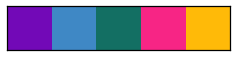

In [22]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
!pip install rich
from rich.console import Console
from rich import print
from rich.theme import Theme
def custom_palette(custom_colors):
    customPalette = sns.set_palette(sns.color_palette(custom_colors))
    sns.palplot(sns.color_palette(custom_colors),size=0.8)
    plt.tick_params(axis='both', labelsize=0, length = 0)

palette = ["#7209B7","#3F88C5","#136F63","#F72585","#FFBA08"]
#palette2 = sns.diverging_palette(120, 220, n=20)
custom_palette(palette)

custom_theme = Theme({
    "info" : "italic bold cyan",
    "warning": "italic bold magenta",
    "danger": "bold blue"
})

console = Console(theme=custom_theme)

In [4]:
# Read in data
train_df = pd.read_csv(f"{DATASET_PATH}train.csv")
test_df = pd.read_csv(f"{DATASET_PATH}test.csv")

In [6]:
# Print out the first few rows of the data
train_df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [7]:
# Let's have a look at some of the text data
train_df.loc[0, 'excerpt']

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

## Preprocessing the data
There are some common methods for preprocessing the data. Let's write a reusable function for preprocessing.

In [8]:
# Clean and Tokenize all the excerpts
def extract_characters_only(excerpt:str) -> str:
    return re.sub("[^a-zA-Z]", " ", excerpt) # Remove everything without letters

def clean_excerpts(excerpt:str) -> str:
    #print(type(excerpt))
    excerpt_cleaned = extract_characters_only(excerpt)
    #print(type(excerpt_cleaned))
    excerpt_cleaned = excerpt_cleaned.lower() # Convert all words into lowercase
    excerpt_cleaned = word_tokenize(excerpt_cleaned) # Tokenize all words
    excerpt_cleaned = [word for word in excerpt_cleaned if not word in set(stopwords.words("english"))] # Remove stopwords from the list
    excerpt_cleaned = [nltk.WordNetLemmatizer().lemmatize(word) for word in excerpt_cleaned] # Lemmatize all the words
    excerpt_cleaned = " ".join(excerpt_cleaned) # Join all the words back as string from array of strings
    return excerpt_cleaned

# Count Words per Excerpt_Cleaned
def count_words_per_excerpts_cleaned(cleaned_excerpt: str)-> int:
    return len([word for word in cleaned_excerpt.split(' ')])

# Count Sentences per Excerpt
def count_number_of_senteces_per_excerpt(excerpt: str)-> int:
    return len(excerpt.split('.'))

# Count Syllables per Excerpt Cleaned
def syllable_count(word):
    #word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

def count_syllables_per_excerpt(cleaned_excerpt: str)-> int:
    number_of_syllables = 0
    for word in cleaned_excerpt:
        number_of_syllables = number_of_syllables + syllable_count(word)
    return number_of_syllables



# Count POS Tag frequencies
def get_pos_tag_frequency(excerpt_cleaned:str)-> dict:
    pos_tags = pos_tag(excerpt_cleaned.split(" ")) # get pos tags for each word
    # print(pos_tags)
    def count_tags(pos_tags):
        tag_count = {}
        for word,tag in pos_tags:
            if tag in tag_count:
                tag_count[tag] += 1
            else:
                tag_count[tag] = 1
        return tag_count
    return count_tags(pos_tags)

# Seperate individual pos tag frequencies into columns
def sep_pos_tag(df):
    tag_name = ['JJ', 'NN']
    def get_pos(x, tag):
        if x.get(tag):
            return x.get(tag)
        else:
            return 0
    for tag in tag_name:
        #print(tag)
        df[tag] = df['pos_tag_freq'].apply(lambda x: get_pos(x, tag))
    return df

In [16]:
from copy import deepcopy
df_processed = deepcopy(train_df)
# Clean and tokenize Excerpts as Excerpt_Cleaned # "excerpts" > "excerpt_cleaned"
df_processed['excerpt_cleaned'] = df_processed['excerpt'].apply(lambda x: clean_excerpts(x))
    

In [24]:
print('>>>>>>>>>> Before Preprocessing')
print(df_processed.loc[0, 'excerpt'])
print('>>>>>>>>>> After Preprocessing')
print(df_processed.loc[0, 'excerpt_cleaned'])

>>>>>>>>>> Before Preprocessing

When the young people returned to the ballroom, it presented a decidedly changed appearance. 
Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps 
and hillocks, like a real snow field. The numerous palms and evergreens that had decorated 
the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond 
dust had been lightly sprinkled on them, and glittering crystal icicles hung from the 
branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was 
called the North Pole, and the other the South Pole. Each player was given a small flag which
they were to plant on reaching the Pole.
This would have been an easy matter, but each traveller was obliged to wear snowshoes.

>>>>>>>>>> After Preprocessing

young people returned ballroom presented decidedly changed appearance instead interior scene 
winter landscape floor covered snow white canvas laid smoothly rumpled bump hillock like real
snow field numerous palm evergreen decorated room powdered flour strewn tuft cotton like snow
also diamond dust lightly sprinkled glittering crystal icicle hung branch end room wall hung 
beautiful bear skin rug rug prize one girl one boy game girl gathered one end room boy one 
end called north pole south pole player given small flag plant reaching pole would easy 
matter traveller obliged wear snowshoe